In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

## Implementation of a Generative Adversarial Network (Goodfellow et al.)

- A GAN learns a sampler that generates data points that have the same distribution as the data distribution.
- It solves an unsupervised learning task
- A GAN consits of a generator network $G$ and a discriminator network $D$

<img src="figures/gan.png" style="width: 400px;"/>

- $G$ is trained to generate fake samples
- $D$ should learn to distinguish fake and real samples
- Boths networks are trained in turns

GAN training tries to solve the following optimization problem

$$ min_G \; max_D \; \mathbb{E}_{X \sim p_{data}} log(D(X)) + \mathbb{E}_{Z \sim p_{latent}} log(1-D(G(Z)))$$

Paper: https://arxiv.org/abs/1406.2661

In [2]:
batch_size = 32
tr = transforms.Compose([transforms.ToTensor()])

training_set = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=tr)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size,
                                              shuffle=True, num_workers=1)

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(50, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 28*28),
            nn.Sigmoid())

    def forward(self, z):
        z = self.model(z)
        z = z.view(-1,1,28,28)
        return z
    
G = Generator()
print(G)

Generator(
  (model): Sequential(
    (0): Linear(in_features=50, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 1),
            nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.model(x)
        return x
    
D = Discriminator() 
print(D)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [5]:
lr = 0.001

opt_G = torch.optim.RMSprop(G.parameters(), lr=lr)
opt_D = torch.optim.RMSprop(D.parameters(), lr=lr)

In [6]:
from util import plot_grid

epoch:  1 batch:  500 loss: 0.8183


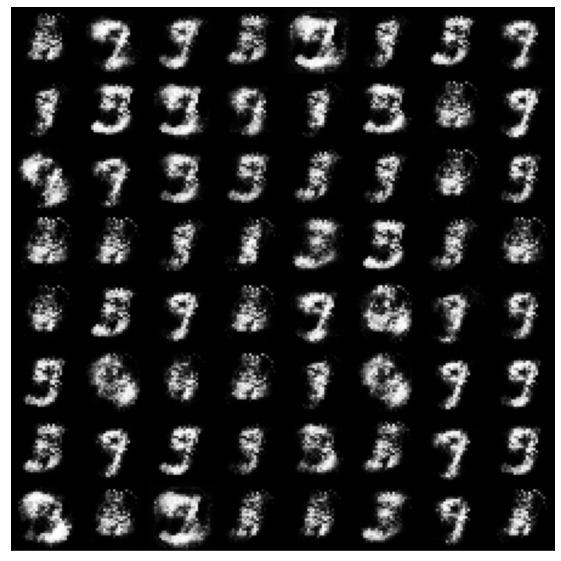

epoch:  1 batch: 1000 loss: 0.7208


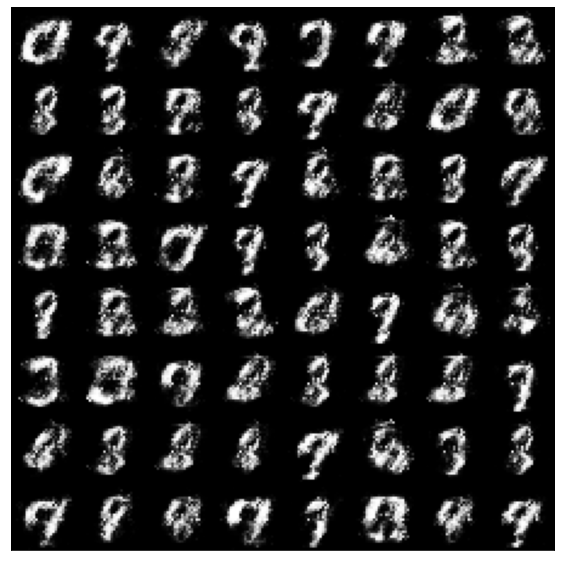

epoch:  1 batch: 1500 loss: 0.7606


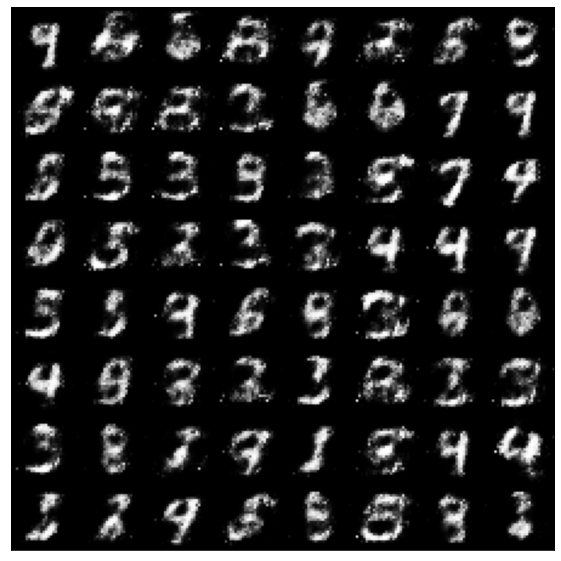

epoch:  2 batch:  500 loss: 1.035


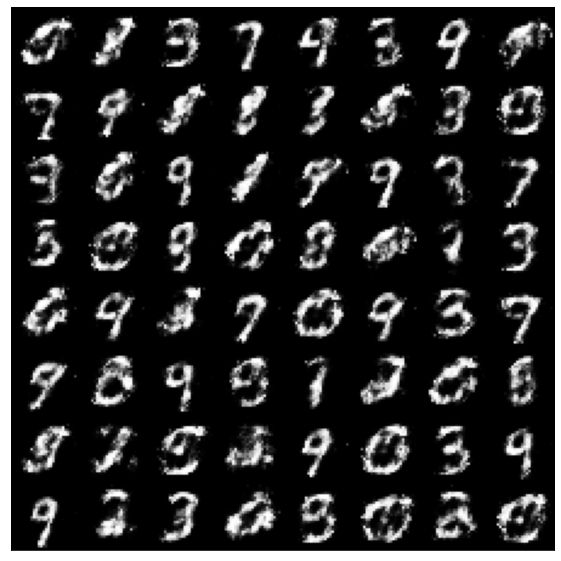

epoch:  2 batch: 1000 loss: 0.3806


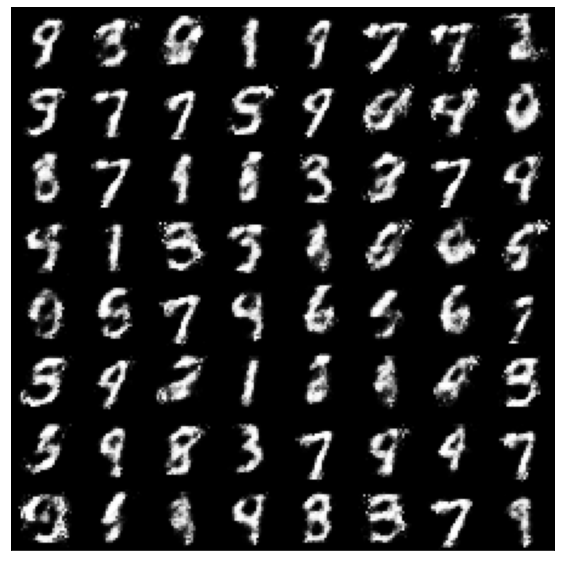

epoch:  2 batch: 1500 loss: 0.5524


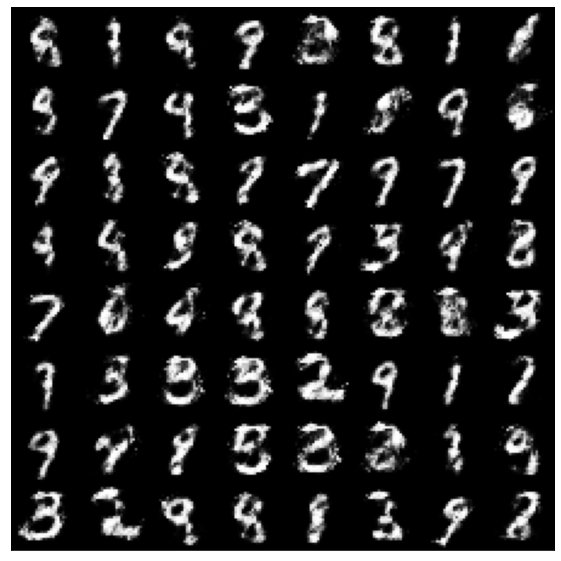

epoch:  3 batch:  500 loss: 0.842


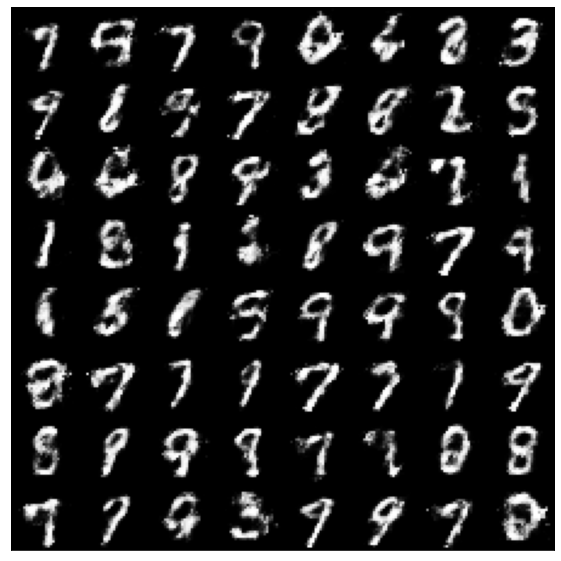

epoch:  3 batch: 1000 loss: 0.9421


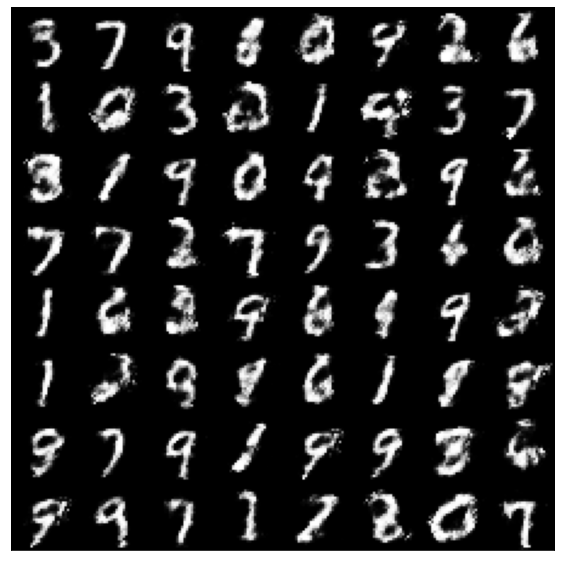

epoch:  3 batch: 1500 loss: 0.5275


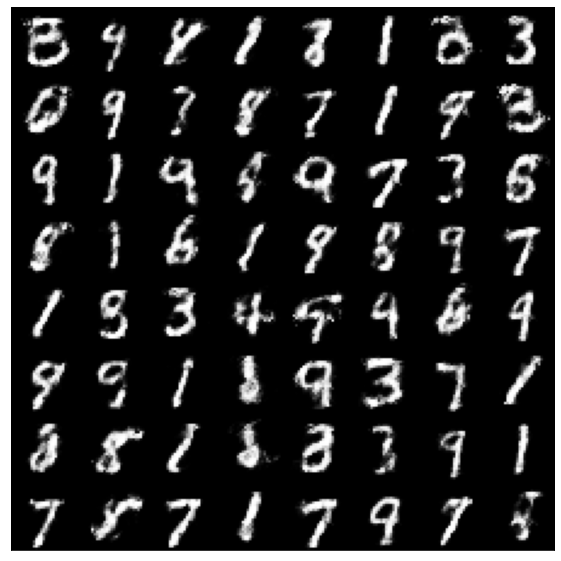

In [7]:
epochs = 3
history = []

for i in range(epochs):
    for j, (x, _) in enumerate(training_loader):
        z = torch.randn(batch_size,1,50)
    
        # Train step D
        opt_D.zero_grad()
        
        loss_D = -torch.log(D(x)).mean()-torch.log(1-D(G(z))).mean()
        history.append(float(loss_D))
        loss_D.backward()
        opt_D.step()
        
        # Train step G
        opt_G.zero_grad()
        loss_G = -torch.log(D(G(z))).mean() # minor modification of the loss
        loss_G.backward()
        opt_G.step()
        
        if (j+1)%500==0:
            print("epoch: {:2} batch: {:4} loss: {:3.4}".format(i+1, j+1, history[-1]))
            z = torch.randn(64,1,50)
            plot_grid(G(z).detach().numpy())

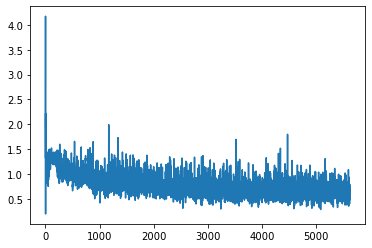

In [8]:
plt.plot(history);

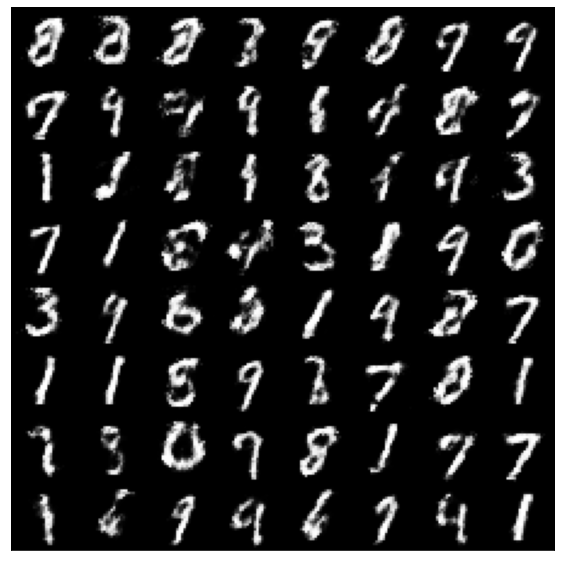

In [9]:
z = torch.randn(64,1,50)
img = G(z).detach().numpy()
plot_grid(img)

In [10]:
# Save model to disk

# torch.save(G.state_dict(), "gan_G")
# torch.save(D.state_dict(), "gan_D")

In [11]:
# Load model
# G = Generator()
# G.load_state_dict(torch.load("gan_G"))
# D = Discriminator()
# D.load_state_dict(torch.load("gan_D"))